# TD 4 | Étude des vibrations des aubes d'un rouet de compresseur d'un turbofan

---

Objectifs du TD :

* pratiquer sur un use case concret d'analyse statistique de données de production aéronautiques
* PCA
* tests statistiques et coefficients de corrélation

---

## Présentation du problème

On considère le **rouet de compresseur** de la **turbine à gaz d'un turbopropulseur** d'hélicoptère. Celui-ci est constitué de 13 **aubes**.

<img src="rc/turbo-helico.png" />

<img src="rc/compresseur.png" /> <img src="rc/compresseur-2.png" />

En production, après la fabrication et montage de la pièce, on mesure les vibrations des aubes grâce à une technique appelée **tip-timing**. Cette technique consiste à mesurer la position d'une aube en rotation par rapport à sa position au repos. En effet, les vibrations dues à la rotation entraînent un **décalage de la position des aubes** (voir schéma ci-dessous). 

<img src="rc/tiptiming.png"/>

La mesure de ce déplacement maximal à un régime (vitesse de rotation) donné permet de déduire le niveau vibratoire de chacune des aubes. Voici les résultats obtenus pour chacune des 13 aubes :

<img src="rc/vibrations.png" />

<div style="color: #bb1111; font-size: 16px; background-color: #ffeeee; padding: 20px; border-radius: 15px">
    <p><b>Problème :</b> on observe un niveau de vibrations anormal pour l'aube numérotée 11 dans le tableau ci-dessus (déplacement maximal de 0.99 mm). Cependant, il est impossible d'identifier de manière certaine cette aube, car l'aube n°1 n'est pas identifiée : il peut y avoir un décalage circulaire des mesures. On sait seulement qu'une aube vibre davantage que les autres. Comment peut-on identifier cette aube afin de la remplacer ?</p>
</div>

## Présentation des données

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p>On dispose de données de production sur les aubes de ce compresseur !</p>
</div>

Durant la production, de nombreuses caractéristiques géométriques de chaque aube sont mesurées. Ces données géométriques sont les suivantes :

* 17 variables géométriques concernant la forme (bord d'attaque BA, bord de fuite BF, etc.) de l'aube
* 94 variables d'épaisseurs mesurées à différents points de l'aube

soit un total de 111 variables mesurées par aube. Ces données se trouvent dans le fichier `Rouet_geometries.csv` (voir figures ci-dessous).

<img src="rc/geometries.png" />
<img src="rc/epaisseurs.png" />

Enfin, les données de vibrations issues du tip-timing se trouvent dans le fichier `Rouet_vibrations.csv`.

<img src="rc/vibrations.png" />

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Attention :</b> Les numérotations des aubes dans les données géométriques et les résultats du tip-timing ne sont pas les mêmes (permutation circulaire) !</p>
</div>

## 1. Chargement et préparation des données

### 1.1 Lecture des données

Charger les deux jeux de données, géométries (`./data/Rouet_geometries.csv`) et vibrations (`./data/Rouet_vibrations.csv`), dans des DataFrames pandas. Il sera nécessaire de prêter attention au format des fichier (header, séparateur de colonnes, typage des colonnes, etc.).

**Indice** : l'encodage des fichier CSV n'est pas UTF-8, il faudra donc préciser l'option `encoding='latin'` à la fonction `pandas.read_csv`.

In [2]:
import pandas as pd
import numpy as np

In [3]:
geometries = pd.read_csv("Rouet_geometries.csv",encoding='latin',header=2,nrows=13,sep=';',decimal=',',index_col=0,engine='python')
geometries.head()


,BA in,MI in,BF intra,BA ex,MI Ex,BF ex,BA in.1,MI in.1,BF intra.1,BA ex.1,...,85,86,87,88,89,90,91,92,93,94
N° Pale,,,,,,,,,,,,,,,,,,,,,
1,0.077,0.064,0.047,0.054,0.035,0.053,4.43,2.03,1.95,4.60,...,121,151,140,143,161,168,180,175,182,194
2,0.068,0.073,0.059,0.056,0.039,0.053,4.44,2.02,1.95,4.59,...,129,155,149,148,172,176,187,185,190,197
3,0.074,0.072,0.055,0.059,0.038,0.047,4.44,2.03,1.95,4.59,...,129,154,146,146,165,173,183,177,185,195
4,0.070,0.076,0.058,0.056,0.037,0.062,4.46,2.02,1.94,4.56,...,125,152,146,146,168,171,186,182,189,196
5,0.086,0.060,0.041,0.042,0.043,0.065,4.42,2.03,1.97,4.61,...,126,150,147,146,164,172,185,178,184,194


In [4]:
vibrations = pd.read_csv("Rouet_vibrations.csv",encoding='latin',header=1,sep=';',decimal=',')
vibrations


,N° Pale,Niveau vibratoire 1FPP (mm),Vitesse de rotation - Régime (RPM)
0,1,0.54,16532.3
1,2,0.60,16538.4
2,3,0.61,16543.6
3,4,0.53,16560.2
4,5,0.43,16550.8
5,6,0.65,16605.0
6,7,0.38,16662.8
7,8,0.43,16615.3
8,9,0.52,16635.0
9,10,0.46,16639.5


### 1.2 Standardisez les variables géométriques afin d'obtenir des variables centrées (moyenne 0) et réduites (variance 1).

In [11]:
"""
##mMéthode 1 
Normalisation:
geometries_norm=geometries.copy()
geometries_norm -= geometries.mean(axis=0)
geometries_norm /= geometries.std(axis=0)
geometries_norm

print(geometries_norm.mean(axis=0), geometries_norm.std(axis=0), sep='\n')

print(np.isclose(geometries_norm.mean(axis=0), 0).all(), np.isclose(geometries_norm.std(axis=0), 1).all())"""
##mMéthode 2
from sklearn.preprocessing import StandardScaler
geometries_norm = pd.DataFrame(data = StandardScaler().fit_transform(geometries.values), columns = geometries.columns)
geometries_norm
vibrations_norm=StandardScaler().fit_transform(vibrations)
vibrations_norm

array([[-1.60356745,  0.03930267, -1.20498957],
       [-1.33630621,  0.42250369, -1.07792086],
       [-1.06904497,  0.48637052, -0.96959999],
       [-0.80178373, -0.02456417, -0.62380644],
       [-0.53452248, -0.66323253, -0.81961724],
       [-0.26726124,  0.74183787,  0.30941953],
       [ 0.        , -0.98256671,  1.51344767],
       [ 0.26726124, -0.66323253,  0.52397818],
       [ 0.53452248, -0.088431  ,  0.93434763],
       [ 0.80178373, -0.47163202,  1.02808685],
       [ 1.06904497,  2.9133103 ,  0.9447631 ],
       [ 1.33630621, -0.91869988,  0.89268576],
       [ 1.60356745, -0.7909662 , -1.45079463]])

## 2. Analyse exploratoire des données

### 2.1 Affichez le niveau vibratoire de chaque aube sur un bar plot

In [12]:
import matplotlib.pyplot as plt

<BarContainer object of 13 artists>

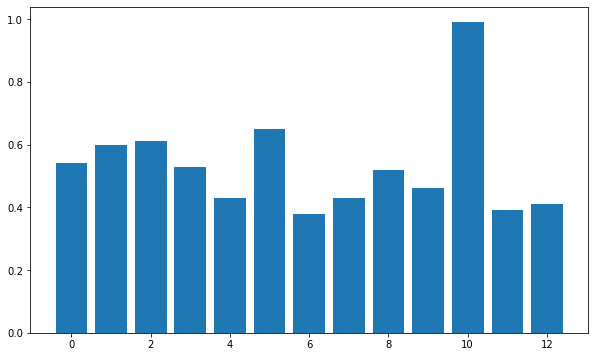

In [13]:
plt.figure(figsize=(10,6)) # la méthode figure permet de créer une nouvelle figure et de configurer ses paramètres
plt.bar(np.arange(vibrations["N° Pale"].size), vibrations["Niveau vibratoire 1FPP (mm)"])

### 2.2 Analyse par ACP de l'importance des variables géométriques

On dispose d'un grand nombre de variables géométriques (111 variables). On souhaite déterminer quelles sont les variables géométriques importantes en analysant leurs poids dans les composantes principales du jeu de données.

#### 2.2.1 Effectuez une ACP sur le jeu de données géométriques, puis calculez et visualisez la part de variance expliquée par chaque composante principale. Interprétez le résultat. Quelle part de variance est expliquée par les 2 premières CP ?

In [14]:
from sklearn.decomposition import PCA

In [15]:
pcamodel = PCA()
pcamodel.fit(geometries_norm.values)
pca=pcamodel.fit_transform(geometries_norm)
pca.shape


(13, 13)

part de variance est expliquée par les 2 premières CP:
84.14341461182345


Text(0.5, 1.0, 'Part de variance expliquée par chaque composante principale')

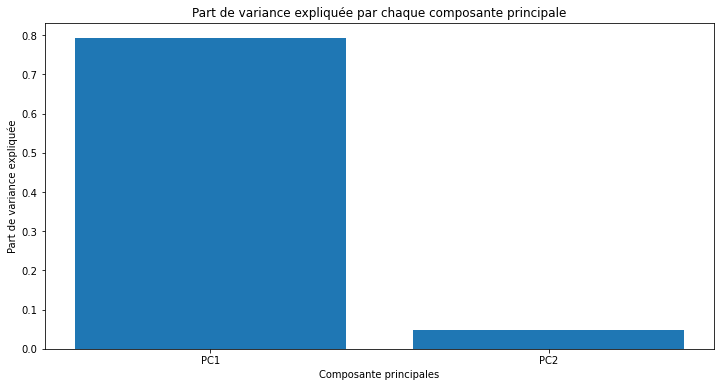

In [23]:
print("part de variance est expliquée par les 2 premières CP:")
print(sum(pcamodel.explained_variance_ratio_[:2])*100)
plt.figure(figsize=(12,6))
plt.bar(x = ["PC"+str(_+1) for _ in range(0, 2)], height= pcamodel.explained_variance_ratio_[:2])
plt.xlabel("Composante principales")
plt.ylabel("Part de variance expliquée")
plt.title("Part de variance expliquée par chaque composante principale")

Une technique très courante pour analyser l'importance des variables est de visualiser leurs poids dans le plan des 2 premières composantes principales.

#### 2.2.2 Visualisez le poids des variables géométriques dans le plan (PC1, PC2)

**Indice 1 :** utilisez pour cela les composantes des vecteurs principaux de la matrice `pca.components_`.

**Indice 2 :** Afin d'obtenir une graphique avec une bonne échelle entre -1 et 1, il est nécessaire d'appliquer aux poids de chaque composante principale un facteur d'échelle égal à $\sqrt{\text{variance expliquée}}$.

Voici le type de graphique, appelé _PCA factor loadings plot_ en anglais, que vous devriez obtenir :

<img src="rc/pca-plot.png" height=500px width=500px />

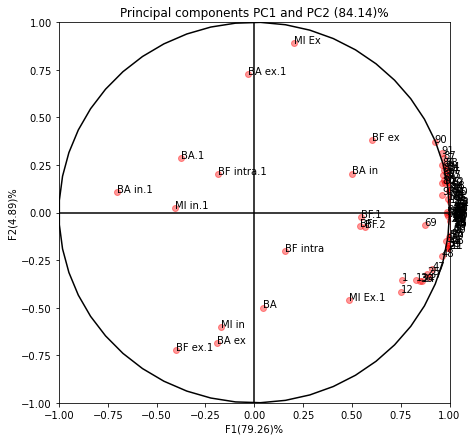

In [65]:
def myplot(score,coeff,labels):
   
   
    PC1 = coeff[0,:]*(sqrt(score.explained_variance_[0]))
    PC2 = coeff[1,:]*(sqrt(score.explained_variance_[1]))
    n = len(PC1)
    plt.figure(figsize=(7,7))

    theta = np.linspace( 0 , 2 * np.pi )  
    xs = np.cos( theta ) 
    ys =  np.sin( theta )
    plt.plot(PC1, PC2, 'ro', alpha = 0.4)
    for i in range(n):
        plt.text(PC1[i], PC2[i], labels[i])
    plt.xlabel("F1({})%".format(np.round(score.explained_variance_ratio_[0]*100,2)))
    plt.ylabel("F2({})%".format(np.round(score.explained_variance_ratio_[1]*100,2)))
    plt.axhline(0, color  = 'k')
    plt.axvline(0, color  = 'k')
    plt.plot(xs,ys, color = 'k')
    plt.title("Principal components PC1 and PC2 ({})%".format(np.round(sum(score.explained_variance_ratio_[:2])*100,2)))
    plt.xlim(-1,1)
    plt.ylim(-1,1)

from math import sqrt

myplot(pcamodel,pcamodel.components_[0:2, :],geometries.columns.values)
plt.show()

#### 2.2.3 Interprétez le graphique précédent. Quelles sont les variables géométriques les plus importantes ?

Les variables d'épaisseurs (numérotées de 1 à 94) sont toutes situées dans la partie la plus à droite du plan des composantes principales. Elles ont donc un poids très important sur la PC1, beaucoup plus que les autres variables géométriques. Étant donné que la PC1 représente presque 80% de la variance, on peut en conclure que les variables d'épaisseurs sont les plus importantes.

## 3. Identification de l'aube anormale par analyse des corrélations

Suite aux analyses précédentes, on décide de se focaliser sur les variables géométriques correspondant aux épaisseurs de l'aube (variables 1-94). Par ailleurs, les experts mécaniciens nous ont informés que les vibrations étaient corrélées à l'épaisseur de l'aube en différentes points. Par conséquent, nous pouvons décrire les données géométriques en utilisant **seulement la première composante principale** : on se ramène donc à un cas **univarié**, avec une seule variable $\text{PC1}$ (projection sur la première composante principale).

**Objectif :** trouver la permutation circulaire des numérotations d'aubes qui **maximise** la corrélation entre vibrations et épaisseurs des aubes, afin d'identifier l'aube défectueuse.

Voici 3 coefficients de corrélation usuels permettant de mesurer l'association de deux variables (ici, $X =\text{PC1} $ et $Y = \text{vibration}$) :

Coefficient de corrélation | formule | lien wikipédia
---------------------------|----------|---------------
Corrélation de Pearson     | $\rho(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)
Corrélation de Spearman    | $\rho_S(X, Y) = \frac{\text{Cov}(\text{rank}(X), \text{rank}(Y))}{\sigma_{\text{rank}_X} \sigma_{\text{rank}(Y)}}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman
Corrélation de Kendall     | $\tau(X, Y) = \frac{2\sum_{i<j}\text{sign}(x_j-x_i)\text{sign}(y_j-y_i)}{N(N-1)}$ | https://fr.wikipedia.org/wiki/Tau_de_Kendall


### 3.1 Quel(s) coefficient(s) vous semble(nt) adapté(s) pour analyser les corrélations entre nos variables ?

pour notre cas c'est la Corrélation de Kendall

### 3.2 Calculez les corrélations pour les 12 décalages circulaires possibles entre les données géométriques et les vibrations. Visualisez-les sur un graphique.

**Indice :** on peut facilement obtenir une permuation circulaire d'un jeu de données à l'aide de la fonction `numpy.roll(...)`.

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Rappel :</b> On n'utilise que la PC1 des variables géométriques !</p>
</div>

Il est recommandé de calculer les _$p$-values_ associées au coefficient de corrélation choisi. Ces valeurs permettent de déterminer si les corrélations trouvées sont **significatives ou non**. La $p$-value est associée aux deux hypothèses statistiques suivantes :

* $\mathcal{H}_0$ : les variables X et Y sont indépendantes (pas de corrélation)
* $\mathcal{H}_1$ : les variables X et Y sont dépendantes (corrélation)

La $p$-value correspond à la **probabilité de se tromper en rejetant l'hypothèse null $\mathcal{H}_0$**. On fait généralement le choix de rejeter l'hypothèse nulle lorsque $p$-value < 0.05, i.e. moins de 5% de chances de se tromper.

In [66]:
import math
def kendall_tau(x, y):
    """Compute Kendall's tau correlation
    
    Arguments
        xs : float array (n)
            input variable 1
        ys : float array (n)
        input variable 2
        
    Returns
        tau : float in [-1, 1]
            correlation coefficient
        pvalue : float
            p-value
    """
    assert x.size == y.size
    size = x.size
    
    tot = (size * (size-1)) // 2
    s = np.array([np.sign(x[j] - x[i]) * np.sign(y[j] - y[i]) for j in range(size) for i in range(j)])
    tau = np.sum(s) / tot
    
    dis = np.sum(s < 0)  # number of discordant pairs
    # Exact p-value, see Maurice G. Kendall, "Rank Correlation Methods" (4th Edition), Charles Griffin & Co., 1970.
    c = min(dis, tot-dis)
    if size <= 0:
        raise ValueError
    elif c < 0 or 2*c > size*(size-1):
        raise ValueError
    elif size == 1:
        pvalue = 1.0
    elif size == 2:
        pvalue = 1.0
    elif c == 0:
        pvalue = 2.0/math.factorial(size) if size < 171 else 0.0
    elif c == 1:
        pvalue = 2.0/math.factorial(size-1) if (size-1) < 171 else 0.0
    else:
        new = [0.0]*(c+1)
        new[0] = 1.0
        new[1] = 1.0
        for j in range(3,size+1):
            old = new[:]
            for k in range(1,min(j,c+1)):
                new[k] += new[k-1]
            for k in range(j,c+1):
                new[k] += new[k-1] - old[k-j]
        pvalue = 2.0*sum(new)/math.factorial(size) if size < 171 else 0.0
        
    return tau, pvalue

[ 0.03930267  0.42250369  0.48637052 -0.02456417 -0.66323253  0.74183787
 -0.98256671 -0.66323253 -0.088431   -0.47163202  2.9133103  -0.91869988
 -0.7909662 ]
[ -2.73338422   0.86682646  -1.19815849  -2.89822306  -0.77885574
 -14.17122881 -10.89847501  -0.97238595   0.53191363  17.25584461
  -9.6037368    4.8292172   19.77064618]


<BarContainer object of 13 artists>

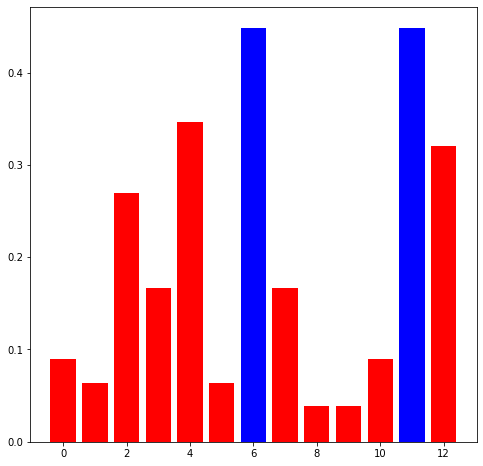

In [67]:
import matplotlib.pyplot as plt

pcamodel1 = PCA(n_components=1)
PC1 = pcamodel1.fit_transform(geometries_norm).squeeze(1)
Y = np.array(vibrations_norm[:,1])
print(Y)
print(PC1)
plt.figure(figsize=(8,8))
tau_list = []
pvalue_list = []
color_list=[]
abs_tau=[]
for i in range(13) :
    Y = np.roll(Y,1)
    tau, pvalue = kendall_tau(PC1, Y)
    if pvalue>0.05:
        color_list.append("red")
    else:
        color_list.append("blue")

    tau_list.append(tau)
    abs_tau.append(abs(tau))
    pvalue_list.append(pvalue)


plt.bar(range(13),abs_tau, color = color_list)

### 3.3 Quel est le décalage circulaire qui maximise la corrélation ? (il peut éventuellement en y avoir plusieurs) Peut-on en déduire l'aube anormale ?

Les décalages circulaires qui maximisent la corrélation sont la 6 et la 11.
Donc on peut pas déduire l'aube anormale.


### 3.4 L'analyse de la PC1 ne s'est pas révélée suffisante, une analyse plus fine est nécessaire. Calculez, pour chaque décalage circulaire de la numérotation des aubes, les corrélations entre toutes les variables d'épaisseur (94 variables) et le niveau vibratoire. Concluez sur l'identité de l'aube défaillante, ainsi que sur la zone précise du défaut.